In [137]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import heapq as hq

import numpy as np

from scipy.stats import truncnorm

from tqdm.notebook import trange

tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
def gumbel_sample(shape, loc=0.):
    
    return -tf.math.log(-tf.math.log(tf.random.uniform(shape=shape))) + tf.convert_to_tensor(loc, dtype=tf.float32)

def trunc_gumbel_sample(shape, loc=0., limit=np.inf):
    
    loc = tf.convert_to_tensor(loc, dtype=tf.float32)

    if tf.math.is_inf(limit):
        return gumbel_sample(shape, loc)
    
    u = tf.random.uniform(shape=shape)
    
    return -tfp.math.log_add_exp((loc - limit), tf.math.log(-tf.math.log(u))) + loc

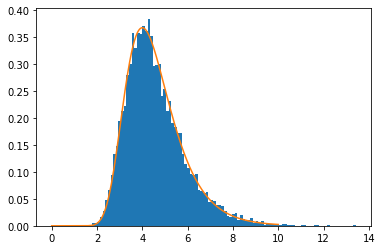

In [3]:
mu = 4 
a = 3

xs = np.linspace(mu - 4, mu + 6, 300)

plt.hist(gumbel_sample(shape=(10000,), loc=mu), bins=100, density=True)
plt.plot(xs, np.exp(-np.exp(mu - xs) + (mu - xs)))
plt.show()

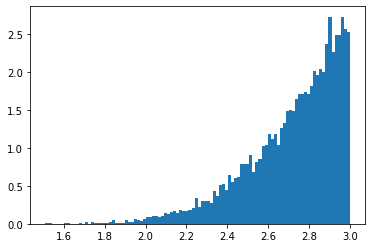

In [4]:
plt.hist(trunc_gumbel_sample(shape=(10000,), loc=mu, limit=3.), bins=100, density=True)
plt.show()

In [5]:
def discrete_sample(log_probs):
    return tf.argmax(log_probs + gumbel_sample(log_probs.shape))

def discrete_kl(p, q):
    return tf.reduce_sum(p * (tf.math.log(p) - tf.math.log(q)))

In [39]:
def harsha_rejection_sampling(target, proposal):
    """
    target and proposal must be vectors of equal length
    """
    
    p = tf.zeros_like(proposal)
    p_star = 0.

    iteration = 0
    
    alphas = []
    betas = []
    
    for i in range(30):
        iteration = iteration + 1
        
        alpha = tf.minimum(target - p, (1 - p_star) * proposal)
        
        sample = discrete_sample(proposal)
        
        beta = alpha / ((1 - p_star) * proposal)
        
        p = alpha + p
        p_star = tf.reduce_sum(p)
        
        alphas.append(alpha)
        betas.append(beta)
        
    return tf.stack(alphas, axis=0), tf.stack(betas, axis=0)

<BarContainer object of 5 artists>

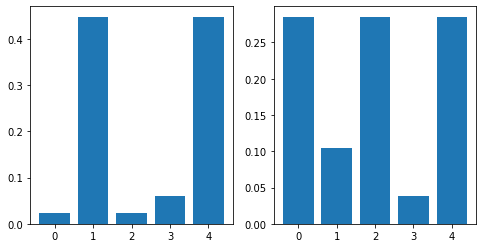

In [40]:
log_target = tf.constant([1,4,1,2,4], dtype=tf.float32)
target = tf.exp(log_target - tf.reduce_logsumexp(log_target))

log_proposal = tf.constant([3, 2, 3, 1, 3], dtype=tf.float32)
proposal = tf.exp(log_proposal - tf.reduce_logsumexp(log_proposal))

indices = tf.range(len(log_target), dtype=tf.float32)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.bar(indices, target)

plt.subplot(122)
plt.bar(indices, proposal)

In [41]:
alphas, betas = harsha_rejection_sampling(target, proposal)

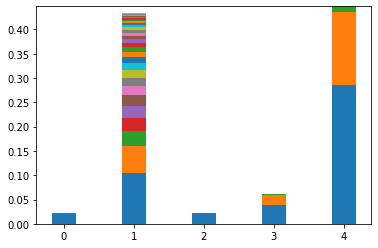

In [42]:
indices = tf.range(len(log_target))
width = 0.35

accept_mass = tf.zeros_like(alphas[0])

for alpha in alphas:
    plt.bar(ind, alpha, width, bottom=accept_mass)
    
    accept_mass += alpha

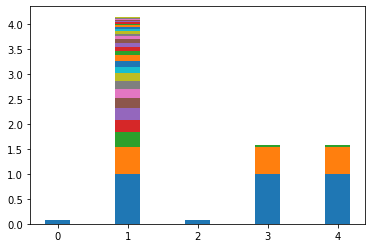

In [179]:
indices = tf.range(len(log_target))
width = 0.35

accept_mass = tf.zeros_like(alphas[0])

for alpha in alphas:
    plt.bar(ind, alpha / proposal, width, bottom=accept_mass / proposal)
    
    accept_mass += alpha

In [38]:
alphas

<tf.Tensor: id=8554, shape=(30, 5), dtype=float32, numpy=
array([[0.022277  , 0.10501195, 0.022277  , 0.03863173, 0.28545207],
       [0.        , 0.05527307, 0.        , 0.02033382, 0.15024777],
       [0.        , 0.03155563, 0.        , 0.0015896 , 0.01174563],
       [0.        , 0.02684155, 0.        , 0.        , 0.        ],
       [0.        , 0.02402287, 0.        , 0.        , 0.        ],
       [0.        , 0.02150018, 0.        , 0.        , 0.        ],
       [0.        , 0.01924241, 0.        , 0.        , 0.        ],
       [0.        , 0.01722172, 0.        , 0.        , 0.        ],
       [0.        , 0.01541324, 0.        , 0.        , 0.        ],
       [0.        , 0.01379466, 0.        , 0.        , 0.        ],
       [0.        , 0.01234606, 0.        , 0.        , 0.        ],
       [0.        , 0.01104958, 0.        , 0.        , 0.        ],
       [0.        , 0.00988924, 0.        , 0.        , 0.        ],
       [0.        , 0.00885075, 0.        , 0

In [43]:
betas

<tf.Tensor: id=10537, shape=(30, 5), dtype=float32, numpy=
array([[0.07804111, 1.        , 0.07804111, 1.        , 1.        ],
       [0.        , 1.        , 0.        , 1.        , 1.        ],
       [0.        , 1.        , 0.        , 0.13693218, 0.13693203],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 

# A* sampling

In [10]:
class MaxHeap:
    
    def __init__(self, init=[]):
        self.heap = []
        
    def push(self, priority, item):
        hq.heappush(self.heap, (-priority, item))
        
    def pop(self):
        priority, item = hq.heappop(self.heap)
        
        return -priority, item
    
    def empty(self):
        return len(self.heap) == 0
    
    def top_priority(self):
        return self.heap[0][1]
    
    def __str__(self):
        return str(self.heap)

In [11]:
heap = MaxHeap([])
print(heap.empty())
heap.push(1, 3)
heap.push(-1, 2)
heap.push(5, 3)
heap.push(4, 2)
print(heap.top_priority())

True
3


In [12]:
def a_star_sample(trunc_proposal_sample, 
                  proposal_log_range_mass, 
                  log_density_ratio, 
                  bounding_region, 
                  eps=1e-6):
    """
    trunc_proposal_sample: takes a tuple representing an interval, and samples from the proposal truncated
    to that interval.
    
    proposal_log_range_mass: takes a tuple representing an interval, and returns the probability mass
    of the proposal in that range.
    
    log_density_ratio: takes a point x and returns log q(x) - log p(x)
    
    bounding_region: takes a tuple representing an interval, and returns an 
    upper bound of the log_density ratio on that region
    """
    
    # Initialize stuff
    noises = []
    prop_samps = []
    bounds = []
    
    lower_bound, sample, k = -np.inf, None, 1
    
    heap = MaxHeap()
    
    # Sample first quantities
    noise = gumbel_sample(shape=(1,))
    prop_samp = trunc_proposal_sample(-np.inf, np.inf)
    bound = bounding_region(-np.inf, np.inf)
    
    noises.append(noise)
    prop_samps.append(prop_samp)
    bounds.append(bound)
    
    # Add initial bound to the heap
    heap.push(1, noise + bound)
    
    while not heap.empty() and lower_bound < heap.top_priority():
        
        p, prop = heap.pop()
        
        current_lower_bound = noises[p] + log_density_ratio(prop_samps[p])
        
        # If we find a better lower bound, set it to be the new one
        if lower_bound < current_lower_bound:
            lower_bound = current_lower_bound
            sample = prop_samps[p]
            
        # Split the interval on the current sample
        left, right = (bounds[p][0], prop_samps[p]), (prop_samps[p], bounds[p][1])
        
        for part in (left, right):
            
            # If the region becomes too small, stop searching
            if part[1] - part[0] < eps:
                continue
                
            # Increment the sample counter
            k = k + 1
            
            # Assign the part under scrutiny as the new bounds
            bounds.append(part)
            
            # Sample new noise
            noise = trunc_gumbel_sample(shape=(1,), 
                                        loc=proposal_log_range_mass(part),
                                        limit=prop_samps[p])
            
            noises.append(noise)
            
            # Sample new location
            prop_samp = trunc_proposal_sample(part)
            prop_samps.append(prop_samp)
 
            # Check if region is worth investigating further
            if lower_bound < noise + bounds[p]:
            
                # Create refined upper bound for region
                bound = bounding_region(part)
                bounds.append(bound)
                
                # Check if region is worth investigating with refined bound
                if lower_bound < noise + bound:
                    heap.push(k, noise + bound)
                    
            else:
                # We append a bound anyway, so that the indexing stays consistent
                bounds.append(None)

In [13]:
a_star_sample(trunc_proposal_sample, 
              proposal_log_range_mass, 
              log_density_ratio, 
              bounding_region)

$
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\bit}{\text{bit}}
\newcommand{\diag}{\text{diag}}
$

# MoG auxiliary variable builder

We want to build a $D$-dimensional MoG random variable with $2^c$ components ($c \in \mathbb{N}$) with equal mixture weights:

$$
    X \sim 2^{-c} \sum_{i = 1}^{2^c} \Norm(\mu_i, \diag(\sigma^2_i)) = p_X(x).
$$

We wish to build it from $c$ 2-component auxiliary mixtures:
$$
    A_k \sim \frac12 \Norm(m_{k, 0}, \diag(s^2_{k, 0})) + \frac12 \Norm(m_{k, 1}, \diag(s^2_{k, 1})),
$$

such that

$$
    \sum_{k = 1}^{c} A_k \sim p_X(x).
$$

To achieve this, we can write down the following constraints that must be satisfied:

$$
    \mu_i = \sum_{k = 1} m_{k, \bit(i - 1, k)} \\
    \sigma^2_i = \sum_{k = 1} s^2_{k, \bit(i - 1, k)},
$$
where $\bit(n, k)$ denotes the $k$th bit of the binary representation of $n$.

Let 

$$
    \mu = \begin{bmatrix} 
    | & | & & |\\ 
    \sigma^2_1 & \sigma^2_2 & ...& \sigma^2_{2^c} \\ 
    | & | & & |
    \end{bmatrix}^T \in \mathbb{R}^{2^c \times D}
    \quad\text{and}\quad 
    \Sigma =     
    \begin{bmatrix} 
    | & | & & |\\ 
    \mu_1 & \mu_2 & ...& \mu_{2^c} \\ 
    | & | & & |
    \end{bmatrix}^T \in \mathbb{R}^{2^c \times D}\\
    M = \begin{bmatrix} 
    | & | & | && |\\ 
    m_{1,0} & m_{1,1} & m_{2, 0} & ...& m_{c, 1} \\ 
    | & | & | && |
    \end{bmatrix}^T \in \mathbb{R}^{2c \times D}
    \quad\text{and}\quad
    S = \begin{bmatrix} 
    | & | & | && |\\ 
    s^2_{1,0} & s^2_{1,1} & s^2_{2, 0} & ...& s^2_{c, 1} \\ 
    | & | & | && |
    \end{bmatrix}^T \in \mathbb{R}^{2c \times D}
$$

and
$$
    \Lambda \in \mathbb{R}^{2^c \times 2c} \\
    \Lambda_{i,2k} = \begin{cases}
        1 & \text{if } \bit(i, k) = 0 \\
        0 & \text{otherwise}
    \end{cases} \\
    \Lambda_{i,2k + 1} = \begin{cases}
        1 & \text{if } \bit(i, k) = 1 \\
        0 & \text{otherwise}
    \end{cases}.
$$

Then, we can write our constraints to be satisfied, as 

$$
    \Lambda M = \mu \\
    \Lambda S = \Sigma.
$$

Thus, to obtain $M$ and $S$, we simply pseudo-invert $\Lambda$ and calculate:

$$
    M = (\Lambda^T\Lambda)^{-1}\Lambda^T\mu \\
    S = (\Lambda^T\Lambda)^{-1}\Lambda^T\Sigma \\
$$

**Note:** This method is doomed, because $\Lambda$ is very non-invertible 

# Different auxiliary MoG builder

we can build an arbitrary component MoG (let's say $C$ components):

$$
    X \sim \frac1C \sum_{i = 1}^C \Norm(x \mid \mu_i, \sigma^2_i) = p_X(x)
$$

by using a $C$-component "base" MoG, and adding on as many auxiliary Normals as we want.

Let

$$
    B \sim \frac1C \sum_{i = 1}^C \Norm(x \mid \mu_{b, i}, \sigma^2_{b, i}),
$$
where $\mu_{b, i} = \mu_i - m$ and $\sigma^2_{b, i} = \sigma^2_i - s^2$ for fixed $m$ and $s$. Let
$$
    A_k \sim \Norm(x \mid m_k, s^2_k),
$$
such that $\sum_{k = 1}^K m_k = m$ and $\sum_{k = 1}^K s^2_k = s^2$.

Then,

$$
    B + \sum_{k = 1}^K A_k \sim p_X(x)
$$

In [84]:
def get_bit(n, k):
    """
    Fast way of getting kth bit of n
    """
    return int(not not(n & (1 << k)))

In [148]:
tf.random.set_seed(42)

c = 10

mus = tf.random.uniform(minval=-5., maxval=5., shape=(2**c, 30))
sigmas = tf.math.exp(tf.random.uniform(minval=-5., maxval=5., shape=(2**c, 30)))

lamb = np.zeros((2**c, 2*c))

for i in range(2**c):
    for k in range(c):
        lamb[i, 2 * k + 1] = get_bit(i, k)
        lamb[i, 2 * k] = 1 - lamb[i, 2 * k + 1]
        
lamb = tf.convert_to_tensor(lamb, dtype=tf.float32)

In [176]:
ms = tf.Variable(tf.zeros((2*c, 30)))

optimizer = tf.optimizers.SGD(1e-20)

for i in trange(1000):
    
    with tf.GradientTape() as t:
        
        loss = tf.math.squared_difference(tf.matmul(lamb, ms), mus)
        loss = tf.reduce_sum(loss)
        
    gradients = t.gradient(loss, ms)
    optimizer.apply_gradients([(gradients, ms)])

In [177]:
tf.reduce_max(tf.abs(tf.matmul(lamb, ms) - mus))

<tf.Tensor: id=162435, shape=(), dtype=float32, numpy=4.9999256>

In [178]:
tf.reduce_mean(tf.abs(tf.matmul(lamb, ms) - mus))

<tf.Tensor: id=162441, shape=(), dtype=float32, numpy=2.4873993>

In [180]:
def pow_unif(x, n, alpha):
    return (1. / (n * alpha) * x ** (1. / alpha - 1))

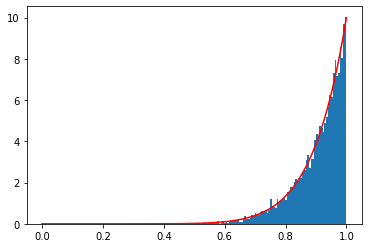

In [195]:
alpha = 0.1

samps = tf.random.uniform(shape=(10000,))
samps = samps ** alpha

xs = tf.linspace(0., 1., 100)

plt.hist(samps, bins=100, density=True)
plt.plot(xs, pow_unif(xs, 1., alpha), c='r')
plt.show()